# *Monitoring of Food System Sustainability* PhD course, Uppsala, HT24
This notebook runs CIBUSmod for a scenario co-designed by participants at the PhD course

### Imports
Add directory with the CIBUSmod modules to path to be able to import

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod'))

Import CIBUSmod and packages for handling data and plotting

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set up scenarios

Instantiate a `Session` object and define scenarios

In [3]:
# Create session
session = cm.Session(
    name = 'phd_lab',
    data_path = '../CIBUSmod/data',
    data_path_scenarios='',
    data_path_output=''
)

In [4]:
years = list(range(2020,2050+1,10))

session.add_scenario(
    name = 'Baseline',
    scenario_workbooks = ['baseline'],
    years = years
)

session.add_scenario(
    name = 'PhD scn',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = years
)

# Here a number of scenarios are defined that step by step
# include additional paramters of the 'PhD scn' scenario
# to be able to asses the impacts of different assumptions
session.add_scenario(
    name = '+demand',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions']
)

session.add_scenario(
    name = '+crops',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction']
)

session.add_scenario(
    name = '+cattle',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd']
)

session.add_scenario(
    name = '+pigs',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd']
)

session.add_scenario(
    name = '+poultry',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd']
)

session.add_scenario(
    name = '+waste',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd', 'WasteAndCircularity']
)

A scenario with the name 'Baseline' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name 'PhD scn' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+demand' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+crops' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+cattle' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+pigs' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+poultry' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+waste' already exists use .update_scenario() or .remove_scenario() instead.


### Run calculations
The code below initiates a process pool that executes the model runs. The `max_workers` paramter to `ProcessPoolExecutor()` defines the maximum number of concurrent processes. The ideal value for this will depend on the computer. The code will print a message every time a scenario run has finnished and if a scenario run fails it will print an error message.

In [5]:
# Import
from concurrent.futures import ProcessPoolExecutor, as_completed
from multi_proc import do_run

# Create list of scenarios/years to run
# runs = [(s,y) for s, y in session.iterate('all')]
# runs = [(s,y) for s, y in session.iterate(['PhD scn'])]
runs = [(s,y) for s, y in session.iterate(['PhD scn','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'])]
runs

[('Baseline', '2020'),
 ('Baseline', '2030'),
 ('Baseline', '2040'),
 ('Baseline', '2050'),
 ('PhD scn', '2020'),
 ('PhD scn', '2030'),
 ('PhD scn', '2040'),
 ('PhD scn', '2050'),
 ('+demand', '2050'),
 ('+crops', '2050'),
 ('+cattle', '2050'),
 ('+pigs', '2050'),
 ('+poultry', '2050'),
 ('+waste', '2050')]

In [6]:
%%time
# Do the multi-processing
with ProcessPoolExecutor(max_workers=8) as executor:
    
    futures = {executor.submit(do_run, session, scn_year) : scn_year for scn_year in runs}

    for future in as_completed(futures):
    
        scn, year = futures[future]
           
        try:
            t = future.result()
        except Exception as ee:
            print(f'(!!!) {scn}, {year} failed with the exception: {ee}')
        else:
            m = int(t/60)
            s = int(round(t - m*60))
            print(f'{scn}, {year} finished successfully in {m}min {s}s')
                    

Baseline, 2020 finished successfully in 4min 6s
Baseline, 2040 finished successfully in 4min 7s
Baseline, 2030 finished successfully in 4min 12s
PhD scn, 2050 finished successfully in 4min 28s
PhD scn, 2020 finished successfully in 4min 30s
PhD scn, 2030 finished successfully in 4min 36s
Baseline, 2050 finished successfully in 4min 37s
PhD scn, 2040 finished successfully in 4min 39s
+crops, 2050 finished successfully in 2min 40s
+cattle, 2050 finished successfully in 3min 19s
+demand, 2050 finished successfully in 3min 36s
+pigs, 2050 finished successfully in 3min 15s
+waste, 2050 finished successfully in 3min 17s
+poultry, 2050 finished successfully in 3min 25s
CPU times: total: 46.9 ms
Wall time: 8min 3s


## Plot output
Here are some example output plots.

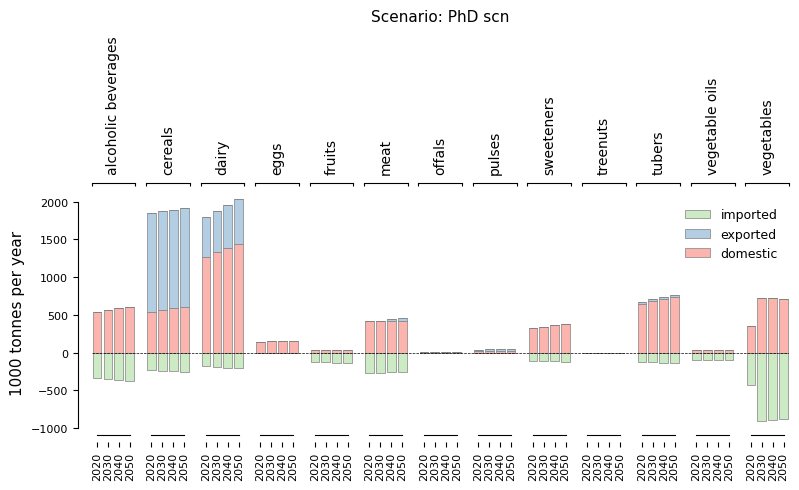

In [10]:
style = {
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'bar_width' : 0.8,
    'group_spacing' : 1,
    'grouplabels_fontsize' : 10,
    'ticklabels_fontsize' : 8,
    'totmarker' : 'none',
    'ylabel' : '1000 tonnes per year'
}

plot_data = (
    session.get_attr(
        module='D',
        attr='food_demand_to_processing',
        groupby=['origin','food_group']
    ).add(
        session.get_attr(
            module='D',
            attr='export_demand',
            groupby=['origin','food_group']
        ).rename(columns={'domestic':'exported'}),
        fill_value = 0
    )
    .stack()
    .fillna(0)
)/1000000
plot_data.loc[:,'imported'] = -plot_data.loc[:,'imported']

fig, ax = plt.subplots(figsize=(9,3))
cm.plot.bar(plot_data.loc['PhD scn'], group_levels='food_group', grouplabels_vertical=True, grouptitle='Scenario: PhD scn', ax=ax, **style)
plt.show()

species  animal                 
cattle   bulls                      1.774485e+05
         calves                     1.507418e+04
         cows                       1.422188e+05
         heifers                    5.257170e+04
         steers                     3.518593e+04
pigs     finishing pigs             2.543216e+06
         sows                       4.350868e+04
poultry  breeding hens              7.536773e+05
         breeding roosters          6.029418e+04
         broilers                   1.056073e+08
         laying hens (>59 weeks)    5.811681e+06
sheep    ewes                       3.917292e+04
         lambs                      1.829549e+05
         rams                       1.597314e+03
Name: (Baseline, 2020), dtype: float64

In [25]:
session.get_attr('a','production',['animal_prod','species','breed','animal']).iloc[0].loc['eggs']/session.get_attr('a','heads',['species','breed','animal']).iloc[0]

species  breed                        animal                    
cattle   beef                         breeding bulls                      NaN
                                      bulls                               NaN
                                      calves                              NaN
                                      cows                                NaN
                                      heifers                             NaN
                                      steers                              NaN
         dairy                        breeding bulls                      NaN
                                      bulls                               NaN
                                      calves                              NaN
                                      cows                                NaN
                                      heifers                             NaN
                                      steers                              NaN

In [21]:
session.get_attr('a','production',['animal_prod','species','animal']).iloc[0].loc['meat']/session.get_attr('a','slaughtered_n',['species','animal']).iloc[0]

species  animal                 
cattle   bulls                      340.580247
         calves                     167.039508
         cows                       316.504782
         heifers                    305.637529
         steers                     330.030434
pigs     finishing pigs              91.809441
         sows                       180.487344
poultry  breeding hens                4.300000
         breeding roosters            5.000000
         broilers                     1.500000
         laying hens (>59 weeks)           NaN
sheep    ewes                        30.056257
         lambs                       20.052207
         rams                        45.540000
Name: (Baseline, 2020), dtype: float64

In [14]:
(session.get_attr('c','harvest',{'crop':'crop_group'})/session.get_attr('c','area',{'crop':'crop_group'})).iloc[0]

crop_group
Berries                    6024.612853
Berries, greenhouse           3.160818
Brassicaceae               3301.974218
Cereals, spring            4641.298369
Cereals, winter            6915.224785
Energy crops               4662.678066
Fallow                     2324.346259
Fodder crops               4681.766255
Fruit trees               16037.315522
Grain legumes              3338.211370
Green manure               4582.210810
Ley                        4960.561826
Nut trees                  1015.139767
Other                      1468.747135
Potatoes                  38501.085951
Semi-natural meadows       3588.253006
Semi-natural pastures      2993.002532
Sugar beet                76519.128902
Vegetables                30792.637392
Vegetables, greenhouse       38.250457
Name: (Baseline, 2020), dtype: float64

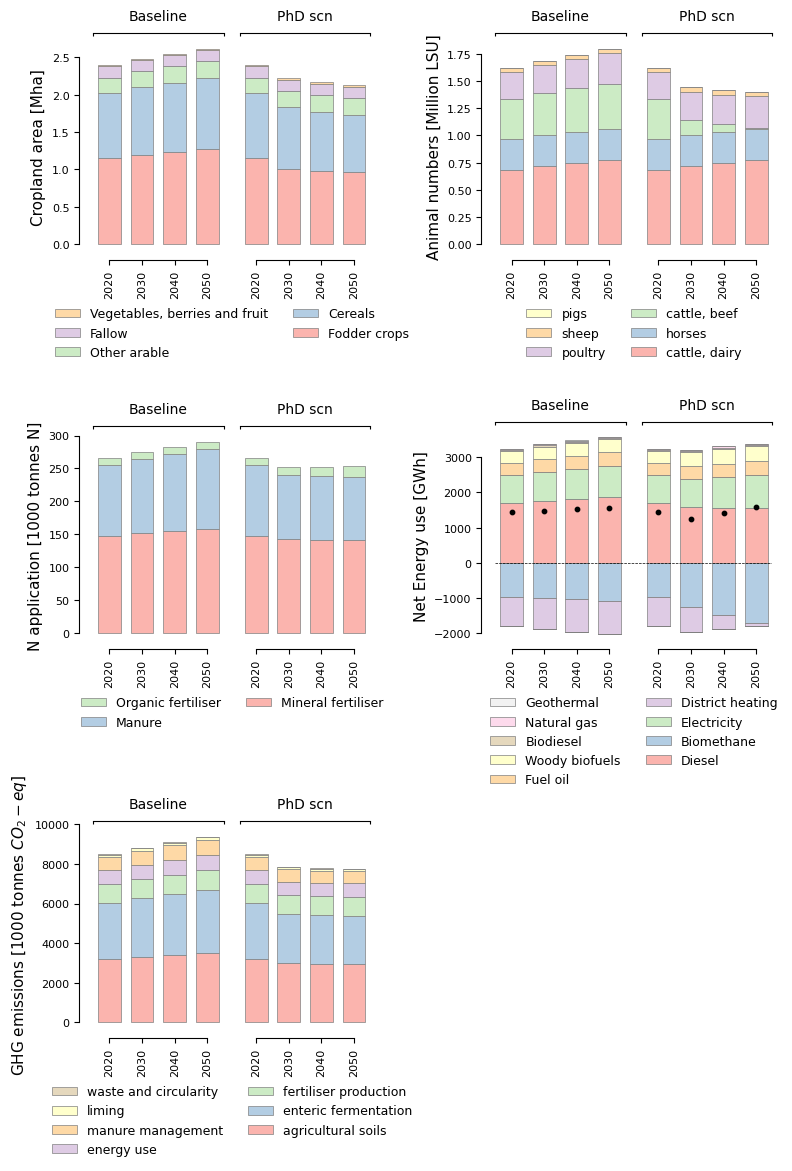

In [11]:
style = {
    'stacked' : True,
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'ticklabels_fontsize' : 8,
    'bar_width' : 0.7
}

def _LSU(x):
    sp,br,an = x
    if sp == 'cattle':
        if an == 'cows':
            if br == 'dairy':
                return 1
            else:
                return 0.8
        elif an == 'calves':
            return 0.4
        elif an == 'breeding bulls':
            return 1
        else:
            return 0.8
    elif sp == 'sheep':
        return 0.1
    elif sp == 'horses':
        return 0.8
    elif sp == 'poultry':
        if an == 'broilers':
            return 0.007
        else:
            return 0.014
    else:
        return np.nan

fig, axs = plt.subplots(3,2, figsize=(8,12))

# Cropland --->
ax = axs[0,0]
plot_data = session.get_attr('C','area',{'crop':'crop_group2'}, scn=['Baseline', 'PhD scn'])/1000000
plot.bar(
    plot_data.drop(['Semi-natural grasslands','Greenhouse crops'], axis=1),
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Cropland area [Mha]'
)

# Animals --->
ax = axs[0,1]
plot_data = session.get_attr('a','heads',['species','breed','animal'], scn=['Baseline', 'PhD scn'])
# Convert to LSU
plot_data = plot_data.mul([_LSU(x) for x in plot_data.columns], axis=1)
# Keep dairy/beef separate
idx = plot_data.columns.to_frame(index=False)
idx['species'] = idx['species'].where(idx['species'] != 'cattle',idx['species']+', '+idx['breed'])
plot_data.columns = pd.MultiIndex.from_frame(idx)
plot_data = plot_data.T.groupby('species').sum().T/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Animal numbers [Million LSU]'
)

# N application --->
ax = axs[1,0]
plot.bar(
    pd.concat([
        session.get_attr('C','fertiliser.mineral_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Mineral fertiliser'),
        session.get_attr('C','fertiliser.manure_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Manure'),
        session.get_attr('C','fertiliser.organic_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Organic fertiliser'),
    ], axis=1)/1_000_000,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='N application [1000 tonnes N]'
)

# Net Energy use --->
ax = axs[1,1]
plot_data = (
    pd.concat([
        session.get_attr('C','energy_use','energy_source', scn=['Baseline', 'PhD scn']),
        session.get_attr('A','energy_use','energy_source', scn=['Baseline', 'PhD scn']),
        session.get_attr('W','energy_use', 'energy_source', scn=['Baseline', 'PhD scn']),
        -session.get_attr('W','energy_prod','energy_prod', scn=['Baseline', 'PhD scn']).rename_axis(columns='energy_source')
    ], axis=1)
    .T.groupby('energy_source').sum().T
)/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Net Energy use [GWh]'
)

# GHG emissions
ax = axs[2,0]
plot_data = (
    cm.get_GHG(session, scn=['Baseline', 'PhD scn'])
    .T.groupby('process').sum().T
)/1000000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel=r'GHG emissions [1000 tonnes $CO_{2}-eq$]'
)

for ax in axs.flatten():
    if ax==axs.flatten()[-1]:
        ax.axis('off')
        continue
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.25), fontsize=9, frameon=False, reverse=True)

plt.tight_layout()
plt.show()

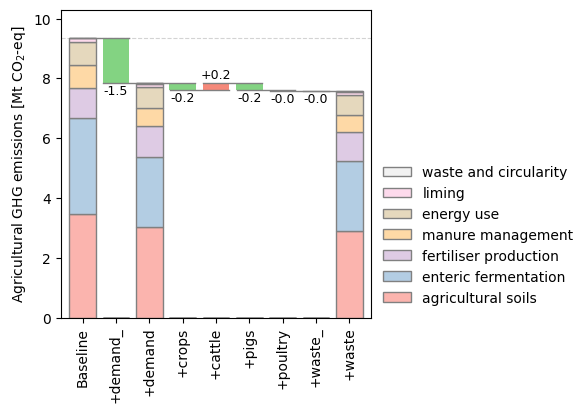

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

plot_data1 = (
    cm.get_GHG(session, scn=['Baseline','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'], years='2050')
    .T.groupby('process').sum().T
    .droplevel('year')
)/1_000_000_000

# Sort
s = plot_data1.loc['Baseline'].sort_values(ascending=False).index

plot.waterfall(
    data=plot_data1.loc[:,s],
    ax=ax,
    breaks = ['+demand'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute',
    label_size=9
)

ax.axhline(y=plot_data1.sum(axis=1).loc['Baseline'], xmin=0, xmax=1, zorder=0, linestyle='--', linewidth=0.8, color='lightgrey')

ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('Agricultural GHG emissions [Mt CO$_2$-eq]')
ax.set_ylim(top=plot_data1.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False, reverse=True)

plt.show()